In [0]:
!pip install tensorflow-gpu
import tensorflow as tf

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [1]:
import random

from keras.models import Model
from keras.layers import Input, GRU, LSTM, Dense, Conv2D, Reshape, MaxPool2D, Flatten, TimeDistributed
import numpy as np
from keras.utils import plot_model
from IPython.display import Image

/home/ressay/workspace/tensorFlow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [74]:
def to_int_onehot(bitlist):
    return np.argmax(bitlist)

def to_int_integer(bitlist):
    return bitlist[0]

def to_int_binary(bitlist):
    out = 0
    for bit in bitlist:
        bit = int(round(bit))
        out = (out << 1) | bit
    return out
  
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

def integer_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array([num])

def onehot_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    arr = np.zeros(m)
    arr[num] = 1
    return arr
  
def print_graphs(graphs):
    for graph in graphs:
        for triplet in graph:
            s,p,o = triplet[:node_encoding_size],\
                    triplet[node_encoding_size:node_encoding_size+edge_encoding_size],\
                    triplet[-node_encoding_size:]
            print(to_int(s),":",to_int(p),":",to_int(o))

In [163]:
w = 32
h = 32
hidden_state_dim = w*h
BINARY, ONE_HOT, INTS = 0,1,2
t = 0 # 0 for binary, 1 for one_hot, 2 for integers
node_size = 9
edge_size = 7
if not t:
    # each node is encoded in x bits
    node_encoding_size = node_size
    # each edge is encoded in x bits
    edge_encoding_size = edge_size
    m_node = 2**node_encoding_size
    m_edge = 2**edge_encoding_size
    to_int = to_int_binary
    to_array = bin_array
elif t == 1:
    # each node is encoded in x bits
    node_encoding_size = 2**node_size
    # each edge is encoded in x bits
    edge_encoding_size = 2**edge_size
    m_node = node_encoding_size
    m_edge = edge_encoding_size
    to_int = to_int_onehot
    to_array = onehot_array
else:
    node_encoding_size = 1
    # each edge is encoded in x bits
    edge_encoding_size = 1
    m_node = 2**node_size
    m_edge = 1**edge_size
    to_int = to_int_integer
    to_array = integer_array
batch_size = 64
epochs = 100
# size is number of triplets, each triplet has 2 nodes and 1 edge
triplet_size = node_encoding_size*2+edge_encoding_size

graph_size = 40

In [164]:
def compare(t1,t2):
    for i in range(3):
        if t1[i] < t2[i]:
            return 1
        if t1[i] > t2[i]:
            return -1
    return 0

def partition(array, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if compare(array[i],array[begin]) <= 0:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    return pivot



def quicksort(array, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    def _quicksort(array, begin, end):
        if begin >= end:
            return
        pivot = partition(array, begin, end)
        _quicksort(array, begin, pivot-1)
        _quicksort(array, pivot+1, end)
    return _quicksort(array, begin, end)

In [165]:
def random_graph_triples(size, nSize, eSize):
    triplets = np.zeros((size, triplet_size))
    num_n, num_e = max((2,size)),max((2,size))
    possible_nodes = [int(random.uniform(1,nSize)) 
                      for i in range(num_n)]
    possible_edges = [int(random.uniform(1,eSize)) 
                      for i in range(num_e)]
    for i in range(size):
        s = to_array(possible_nodes[int(random.uniform(0, num_n-1))],
                     node_encoding_size)
        o = to_array(possible_nodes[int(random.uniform(0, num_n-1))],
                     node_encoding_size)
        p = to_array(possible_edges[int(random.uniform(0, num_e-1))],
                     edge_encoding_size)
        triplets[i, :] = np.concatenate((s, p, o))
    return triplets

def random_graph_triples_ordered(size, nSize, eSize):
    triplets = np.zeros((size, triplet_size))
    num_n, num_e = max((2,size)),max((2,size))
    possible_nodes = [int(random.uniform(1,nSize)) 
                      for i in range(num_n)]
    possible_edges = [int(random.uniform(1,eSize)) 
                      for i in range(num_e)]
    graph = []
    for i in range(size):
        graph.append((possible_nodes[int(random.uniform(0, num_n-1))],
                      possible_edges[int(random.uniform(0, num_e-1))],
                     possible_nodes[int(random.uniform(0, num_n-1))]))
    quicksort(graph)
    for i,(s,p,o) in enumerate(graph):
        s = to_array(s, node_encoding_size)
        o = to_array(o, node_encoding_size)
        p = to_array(p, edge_encoding_size)
        triplets[i, :] = np.concatenate((s, p, o))
    return triplets



def graph_train_generator_RNN(mi_size, ma_size, nSize, eSize):
    while True:
        size = int(random.uniform(mi_size, ma_size))
        x_encoder = np.zeros((batch_size, size, triplet_size))
        x_decoder = np.zeros((batch_size, size + 1, triplet_size))
        y_decoder = np.zeros((batch_size, size + 1, triplet_size))
        for i in range(batch_size):
            x_encoder[i, :, :] = random_graph_triples(size, nSize, eSize)
            # decoder starts with zeros and is one timestep late
            x_decoder[i, 1:, :] = x_encoder[i, :, :]
            y_decoder[i:, :-1, :] = x_encoder[i, :, :]
        y = [
            y_decoder[:,:,:node_encoding_size],
            y_decoder[:,:,node_encoding_size:-node_encoding_size],
            y_decoder[:,:,-node_encoding_size:]
            ]    
        if t != 1:
            y = y_decoder
        yield [x_encoder, x_decoder],y

def graph_train_generator_Dense(mi_size, ma_size, nSize, eSize):
    if ma_size > graph_size:
        ma_size = graph_size
    if mi_size > graph_size:
        mi_size = graph_size-1
    while True:
        size = int(random.uniform(mi_size, ma_size))
        x_encoder = np.zeros((batch_size, size, triplet_size))
        y_decoder = np.zeros((batch_size, graph_size, triplet_size))
        for i in range(batch_size):
            x_encoder[i, :, :] = random_graph_triples(size, nSize, eSize)
            # decoder starts with zeros and is one timestep late
            y_decoder[i, :size, :] = x_encoder[i, :, :]
        yield x_encoder, y_decoder

In [ ]:
batch_size = 1
gen = graph_train_generator_RNN(3,3,10,10)
for x,y in gen:
  print(x)
  print(y[0].shape)
  print(y[1].shape)
  print(y[2].shape)
  break
batch_size = 256


#Encoder types

In [166]:
def create_encoder_lstm(inputs,return_state=True):
    # Define an input sequence and process it.
    #inputs = Dense(triplet_size*6,activation='relu')(inputs)
    #inputs = Dense(triplet_size*12,activation='relu')(inputs)
    encoder = LSTM(hidden_state_dim, return_state=return_state)
    encoder_output, state_h, state_c = encoder(inputs)
    
    encoder_state = [state_h, state_c]
    return encoder_output, encoder_state

def create_encoder_gru(inputs,return_state=True):
    # Define an input sequence and process it.
    #inputs = Dense(triplet_size*6,activation='relu')(inputs)
    #inputs = Dense(triplet_size*12,activation='relu')(inputs)
    encoder = GRU(hidden_state_dim, return_state=return_state)
    encoder_outputs, encoder_state = encoder(inputs)
    # We discard `encoder_outputs` and only keep the states.
    return encoder_outputs, encoder_state

#Decoder types

In [167]:
# only works with encoder_state generated from lstm encoder
def create_decoder_lstm(encoder_state,inputs):
    decoder_lstm = LSTM(hidden_state_dim, return_sequences=True,
                        return_state=True)
    decoder_outputs, _, _ = decoder_lstm(inputs,
                                         initial_state=encoder_state)
    return decoder_outputs

# only works with encoder_state generated from lstm encoder
def create_decoder_gru(encoder_state,inputs):
    decoder_gru = GRU(hidden_state_dim, return_sequences=True,
                      return_state=True)
    decoder_outputs, _ = decoder_gru(inputs,
                                         initial_state=encoder_state)
    return decoder_outputs

def create_decoder_dense(encoder_state):
    decoder_dense = Dense(hidden_state_dim*4,
                          activation='relu')(encoder_state)
    #decoder_dense = Dense(hidden_state_dim*2,
    #                      activation='tanh')(decoder_dense)
    decoder_dense = Dense(triplet_size*graph_size,
                          activation='sigmoid')(decoder_dense)
    decoder_dense = Reshape((graph_size,triplet_size))(decoder_dense)
    return decoder_dense
  

def create_decoder_cnn(encoder_state):
    decoder_dense = Reshape((w,h,1))(encoder_state)
    decoder_dense = Conv2D(16,5,activation='relu')(decoder_dense)
    decoder_dense = MaxPool2D((2,2))(decoder_dense)
    decoder_dense = Conv2D(32,5,activation='relu')(decoder_dense)
    decoder_dense = MaxPool2D((2,2))(decoder_dense)
    decoder_dense = Flatten()(decoder_dense)
    decoder_dense = Dense(triplet_size*graph_size,
                          activation='sigmoid')(decoder_dense)
    decoder_dense = Reshape((graph_size,triplet_size))(decoder_dense)
    return decoder_dense

#Output unit after decoder

In [168]:
def create_output_unit_cnn():
    unit_inputs = Input(shape=(None,hidden_state_dim))
    print(unit_inputs.shape)
    reshaper = TimeDistributed(Reshape((32, 16,1)))
    unit_outputs = reshaper(unit_inputs)
    unit_outputs = TimeDistributed(Conv2D(16, 3,
                                          activation='relu'))(unit_outputs)
    unit_outputs = TimeDistributed(MaxPool2D(pool_size=(4, 4)))(unit_outputs)
    unit_outputs = TimeDistributed(Flatten())(unit_outputs)
    decoder_dense = TimeDistributed(Dense(triplet_size, activation='sigmoid'))
    unit_outputs = decoder_dense(unit_outputs)
    
    return Model(unit_inputs,unit_outputs)

def create_output_unit_dense():
    unit_inputs = Input(shape=(None,hidden_state_dim))
    decoder_dense = Dense(triplet_size, activation='sigmoid')
    unit_outputs = decoder_dense(unit_inputs)
    
    return Model(unit_inputs,unit_outputs)
  
def create_output_unit_dense_onehot():
    unit_inputs = Input(shape=(None,hidden_state_dim))
    unit_outputs1 = Dense(node_encoding_size, activation='softmax',
                          name='s')(unit_inputs)
    unit_outputs2 = Dense(edge_encoding_size, activation='softmax',
                          name='p')(unit_inputs)
    unit_outputs3 = Dense(node_encoding_size, activation='softmax',
                          name='o')(unit_inputs)
    
    return Model(unit_inputs,[unit_outputs1,unit_outputs2,unit_outputs3])

#Creating Model RNN Decoder

In [0]:
encoder_inputs = Input(shape=(None, triplet_size))
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, triplet_size))

create_encoder = create_encoder_gru
create_decoder = create_decoder_gru
if t == 1:
  create_unit = create_output_unit_dense_onehot
else:
  create_unit = create_output_unit_dense

encoder_output,encoder_state = create_encoder(encoder_inputs)
decoder_output = create_decoder_gru(encoder_state,decoder_inputs)
unit = create_unit()
decoder_output = unit(decoder_output)

model = Model([encoder_inputs,decoder_inputs],decoder_output)
loss='binary_crossentropy'
loss_weight = [1]
if t==1:
  loss = ['categorical_crossentropy',
          'categorical_crossentropy',
          'categorical_crossentropy'
         ]
  loss_weight = [1,1,1]
model.compile(optimizer='rmsprop', loss=loss,metrics=['accuracy'],loss_weights=loss_weight)

In [0]:
# import keras
# model = keras.models.load_model('model.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, 1152)   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None, 1152)   0                                            
__________________________________________________________________________________________________
gru_3 (GRU)                     [(None, 1024), (None 6687744     input_4[0][0]                    
__________________________________________________________________________________________________
gru_4 (GRU)                     [(None, None, 1024), 6687744     input_5[0][0]                    
                                                                 gru_3[0][1]                      
__________

In [ ]:
model.fit_generator(graph_train_generator_RNN(1,graph_size,
                    m_node,m_edge),
                    steps_per_epoch=400,
                    epochs=50,use_multiprocessing=True)
# Save model
model.save('model.h5')

In [ ]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model_onehot_dense.h5'})
uploaded.SetContentFile('model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1qK74uj8idj2mpQo_dzm59FzCowwxQT3X


In [0]:
id='1qK74uj8idj2mpQo_dzm59FzCowwxQT3X'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('model.h5')

#Creating Model Dense Decoder

In [0]:
import keras.backend as K

def myAccuracy(y_true, y_pred):
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    diff = K.abs(y_true-y_pred) #absolute difference between correct and predicted values
    correct = K.less(diff,0.05) #tensor with 0 for false values and 1 for true values
    return K.mean(correct) #sum all 1's and divide by the total.

In [180]:
import keras
model = keras.models.load_model('model_binary.h5')

In [181]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, None, 25)     0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, None, 25)     0                                            
__________________________________________________________________________________________________
gru_11 (GRU)                    [(None, 1024), (None 3225600     input_19[0][0]                   
__________________________________________________________________________________________________
gru_12 (GRU)                    [(None, None, 1024), 3225600     input_20[0][0]                   
                                                                 gru_11[0][1]                     
__________

In [0]:
encoder_inputs = Input(shape=(None, triplet_size))
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, triplet_size))

create_encoder = create_encoder_gru
create_decoder = create_decoder_dense
create_unit = create_output_unit_cnn

encoder_output,encoder_state = create_encoder(encoder_inputs)
decoder_output = create_decoder(encoder_output)

model = Model(encoder_inputs,decoder_output)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, None, 25)          0         
_________________________________________________________________
gru_14 (GRU)                 [(None, 1024), (None, 102 3225600   
_________________________________________________________________
dense_11 (Dense)             (None, 4096)              4198400   
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              4097000   
_________________________________________________________________
reshape_5 (Reshape)          (None, 40, 25)            0         
Total params: 11,521,000
Trainable params: 11,521,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit_generator(graph_train_generator_Dense(1,graph_size,
                    m_node,m_edge),
                    steps_per_epoch=400,
                    epochs=100,use_multiprocessing=True)
# Save model
model.save('s2s.h5')

In [183]:
# model.summary()
if t == ONE_HOT:
    model.get_layer('input_4').name = 'input_encoder'
    model.get_layer('input_5').name = 'input_decoder'
    model.get_layer('gru_3').name = 'gru_encoder'
    model.get_layer('gru_4').name = 'gru_decoder'
    model.get_layer('model_3').name = 'output_unit'
elif t == BINARY:
    model.get_layer('input_19').name = 'input_encoder'
    model.get_layer('input_20').name = 'input_decoder'
    model.get_layer('gru_11').name = 'gru_encoder'
    model.get_layer('gru_12').name = 'gru_decoder'
    model.get_layer('model_12').name = 'output_unit'
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      (None, None, 25)     0                                            
__________________________________________________________________________________________________
input_decoder (InputLayer)      (None, None, 25)     0                                            
__________________________________________________________________________________________________
gru_encoder (GRU)               [(None, 1024), (None 3225600     input_encoder[0][0]              
__________________________________________________________________________________________________
gru_decoder (GRU)               [(None, None, 1024), 3225600     input_decoder[0][0]              
                                                                 gru_encoder[0][1]                
__________

In [184]:
input_encoder = model.get_layer('input_encoder').input
gru_encoder = model.get_layer('gru_encoder').output[1]
print(gru_encoder)
encoder_model = Model(input_encoder,gru_encoder)
encoder_model.summary()

Tensor("gru_11/while/Exit_2:0", shape=(?, 1024), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_encoder (InputLayer)   (None, None, 25)          0         
_________________________________________________________________
gru_encoder (GRU)            [(None, 1024), (None, 102 3225600   
Total params: 3,225,600
Trainable params: 3,225,600
Non-trainable params: 0
_________________________________________________________________


In [186]:
# print(model.get_layer('input_decoder').input.shape)
input_decoder = Input(shape=(None,triplet_size))
print(input_decoder.shape)
gru_decoder = model.get_layer('gru_decoder')
input_decoder_state = Input(shape=(hidden_state_dim,))
decoder_output, decoder_state = gru_decoder(input_decoder, initial_state=input_decoder_state)
if t == ONE_HOT:
    s,p,o = model.get_layer('output_unit')(decoder_output)
    decoder_model = Model(inputs=[input_decoder,input_decoder_state],outputs=[s,p,o, decoder_state])
else:
    output = model.get_layer('output_unit')(decoder_output)
    decoder_model = Model(inputs=[input_decoder,input_decoder_state],outputs=[output, decoder_state])
decoder_model.summary()

(?, ?, 25)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, None, 25)     0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           (None, 1024)         0                                            
__________________________________________________________________________________________________
gru_decoder (GRU)               [(None, None, 1024), 3225600     input_36[0][0]                   
                                                                 input_37[0][0]                   
__________________________________________________________________________________________________
output_unit (Model)             (None, None, 25)     25625       gru_decoder[2][0]                

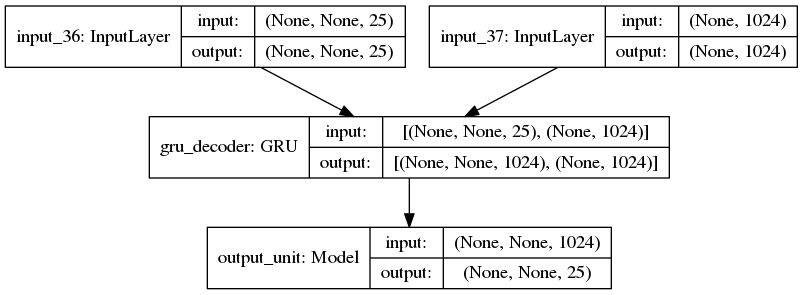

In [187]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

#Decode graph dense/cnn model

In [188]:
def decode_graph(input_graph):
    def isOnes(trip):
        for a in trip:
            if a != 1:
                return False
        return True

    def isZeros(triplet):
        for a in triplet:
            if a != 0:
                return False
        return True

    # Encode the input graph as state vectors.
    states_value = encoder_model.predict(input_graph)
    graph_size = len(input_graph[0])
    print('graph size is: ',graph_size)
    # Generate start input (all zeros).
    target_seq = np.zeros((1, 1, triplet_size))

    stop_condition = False
    decoded_graph = np.zeros((1,input_graph.shape[1]+3,triplet_size))
    i = 0
    while not stop_condition:
#         print(target_seq.shape)
#         print(states_value.shape)
        if t == ONE_HOT:
            s,p,o, states_value = decoder_model.predict(
                [target_seq,states_value])
            triplet = np.concatenate([s[0, -1, :],p[0, -1, :],o[0, -1, :]])
            # Update the target sequence (of length 1).
#             target_seq[0, 0, :] = np.concatenate([s,p,o],axis=2)
#             decoded_graph[0, i, :] = triplet
        else:
            output, states_value = decoder_model.predict(
                [target_seq,states_value])
            triplet = output[0, -1,:]
            # Update the target sequence (of length 1).
        
        # Exit condition: either hit max length
        # or find stop character.
        if isZeros(triplet):
            break
        if i > graph_size + 1:
            print("out because of graph size" , len(decoded_graph))
            break
        target_seq[0, 0, :] = triplet
        decoded_graph[0, i, :] = triplet
        i += 1
        
        
        

    return decoded_graph

In [203]:
dense_output = False
s = 20
print(triplet_size)
graph = np.zeros((1,s,triplet_size))
graph[0,:,:] = random_graph_triples(s,m_node,m_edge)
if dense_output:
    graph_r = model.predict(graph)
else:
    graph_r = decode_graph(graph)
# print_graphs(graph)
right = 0
diff = 0
for t1,t2 in zip(graph[0,:,:],graph_r[0,:,:]):
  s,p,o = t1[:node_encoding_size],\
                    t1[node_encoding_size:node_encoding_size+edge_encoding_size],\
                    t1[-node_encoding_size:]
  s1,p1,o1 = t2[:node_encoding_size],\
                    t2[node_encoding_size:node_encoding_size+edge_encoding_size],\
                    t2[-node_encoding_size:]
  s,p,o,s1,p1,o1 = to_int(s),to_int(p),to_int(o),to_int(s1),to_int(p1),to_int(o1)
  if s == s1 and p == p1 and o == o1:
    right += 1
  else:
    diff += 1
    #print('g1: ',s,p,o,' g2: ',s1,p1,o1)
print('right: ',right, ' diff: ',diff)
print("input graph:")
print_graphs(graph)
print("output graph:")
print_graphs(graph_r)

25
graph size is:  20
out because of graph size 1
right:  17  diff:  3
input graph:
355 : 5 : 162
48 : 11 : 366
183 : 3 : 166
166 : 114 : 503
282 : 5 : 52
106 : 14 : 455
68 : 112 : 101
355 : 21 : 274
124 : 32 : 355
274 : 1 : 366
162 : 79 : 162
101 : 3 : 481
162 : 106 : 282
432 : 32 : 101
274 : 14 : 366
394 : 79 : 274
162 : 3 : 183
68 : 93 : 274
366 : 5 : 481
106 : 102 : 394
output graph:
355 : 5 : 162
48 : 11 : 366
183 : 3 : 166
166 : 114 : 503
282 : 5 : 52
106 : 14 : 455
68 : 112 : 101
355 : 21 : 274
124 : 32 : 355
274 : 1 : 366
162 : 79 : 162
103 : 3 : 481
162 : 106 : 282
434 : 32 : 101
274 : 14 : 366
394 : 79 : 274
162 : 3 : 183
70 : 93 : 274
366 : 5 : 481
106 : 102 : 394
0 : 0 : 0
0 : 0 : 0
0 : 0 : 0
